In [ ]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2021,2,19)
ccr = {ticker: web.get_data_yahoo(ticker, start, end) for ticker in ["CCRO3.SA"]}

In [ ]:
ccr['CCRO3.SA'].head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,10.0500,9.7875,9.9975,10.0250,1447200.0,6.294615
2010-01-05,10.2200,9.9625,10.0000,10.1625,3492400.0,6.380952
2010-01-06,10.6225,10.0750,10.1300,10.5000,5304800.0,6.592864
2010-01-07,10.5750,10.3800,10.4475,10.4025,1464400.0,6.531646
2010-01-08,10.5725,10.3775,10.4400,10.4000,1652000.0,6.530076


In [ ]:
ccr = ccr['CCRO3.SA']

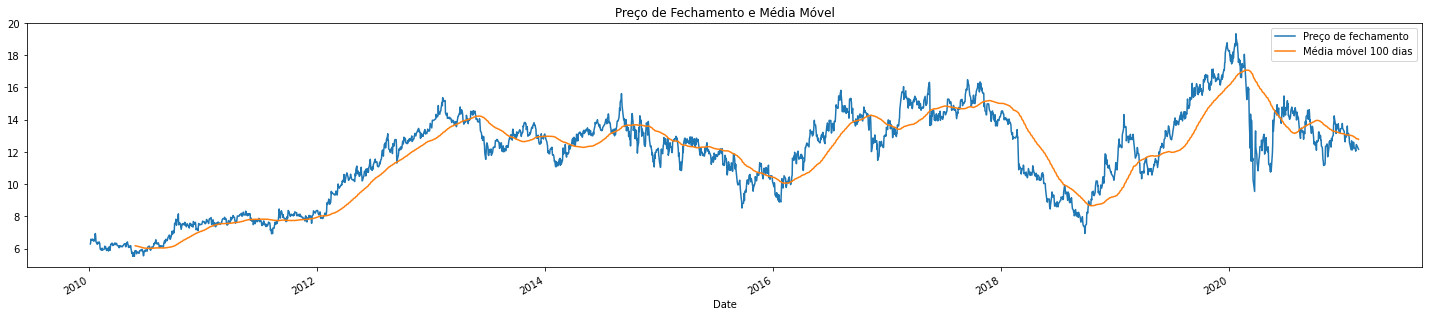

In [ ]:
fig, ax = plt.subplots(figsize=(25,5))

ccr['Adj Close'].plot(label='Preço de fechamento')
ccr['Adj Close'].rolling(100).mean().plot(label='Média móvel 100 dias')
plt.title('Preço de Fechamento e Média Móvel')
plt.legend()

plt.show()

In [ ]:
ccr = pd.DataFrame(ccr.iloc[:,5])

In [ ]:
treino1 = pd.DataFrame(ccr['Adj Close'])
treino1 = treino1['2010':'2019']

In [ ]:
ccr = ccr.dropna()
treino = ccr['2010':"2019"].values

In [ ]:
normalizador = MinMaxScaler(feature_range=(0,1))
treino = normalizador.fit_transform(treino)

In [ ]:
treino.shape

(278, 1)

In [ ]:
previsores = []
preco_real = []

for i in range(90, 2478):
  previsores.append(treino[i-90:i, 0])
  preco_real.append(treino[i, 0])

previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1],1))

In [ ]:
regressor = Sequential()

regressor.add(LSTM(units=100, return_sequences=True, input_shape=(previsores.shape[1], 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1, activation='linear'))

regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs=100, batch_size=32)

Epoch 1/100
75/75 [==============================] - 24s 215ms/step - loss: 0.0530 - mean_absolute_error: 0.1630
Epoch 2/100
75/75 [==============================] - 16s 219ms/step - loss: 0.0113 - mean_absolute_error: 0.0823
Epoch 3/100
75/75 [==============================] - 17s 224ms/step - loss: 0.0083 - mean_absolute_error: 0.0690
Epoch 4/100
75/75 [==============================] - 17s 222ms/step - loss: 0.0081 - mean_absolute_error: 0.0686
Epoch 5/100
75/75 [==============================] - 17s 220ms/step - loss: 0.0072 - mean_absolute_error: 0.0645
Epoch 6/100
75/75 [==============================] - 17s 230ms/step - loss: 0.0054 - mean_absolute_error: 0.0552
Epoch 7/100
75/75 [==============================] - 17s 220ms/step - loss: 0.0050 - mean_absolute_error: 0.0530
Epoch 8/100
75/75 [==============================] - 16s 220ms/step - loss: 0.0047 - mean_absolute_error: 0.0523
Epoch 9/100
75/75 [==============================] - 17s 220ms/step - loss: 0.0039 - mean_absolu

In [ ]:
teste = pd.DataFrame(ccr['2020':"2021"])
teste_real = ccr['2020':"2021"].values

In [ ]:
teste.shape

(278, 1)

In [ ]:
len(base_completa)

2756

In [ ]:
base_completa = pd.concat((treino1['Adj Close'], teste['Adj Close']), axis=0)
entradas = base_completa[len(base_completa) - len(teste) - 90:].values
entradas = entradas.reshape(-1,1)
entradas = normalizador.transform(entradas)

In [ ]:
x_teste = []

for i in range(90,368):
  x_teste.append(entradas[i-90:i, 0])

x_teste = np.array(x_teste)
x_teste = np.reshape(x_teste, (x_teste.shape[0], x_teste.shape[1], 1))

previsao = regressor.predict(x_teste)
previsao = normalizador.inverse_transform(previsao)

In [ ]:
print(previsao.mean())
print(teste_real.mean())

13.712603
13.785010296663792


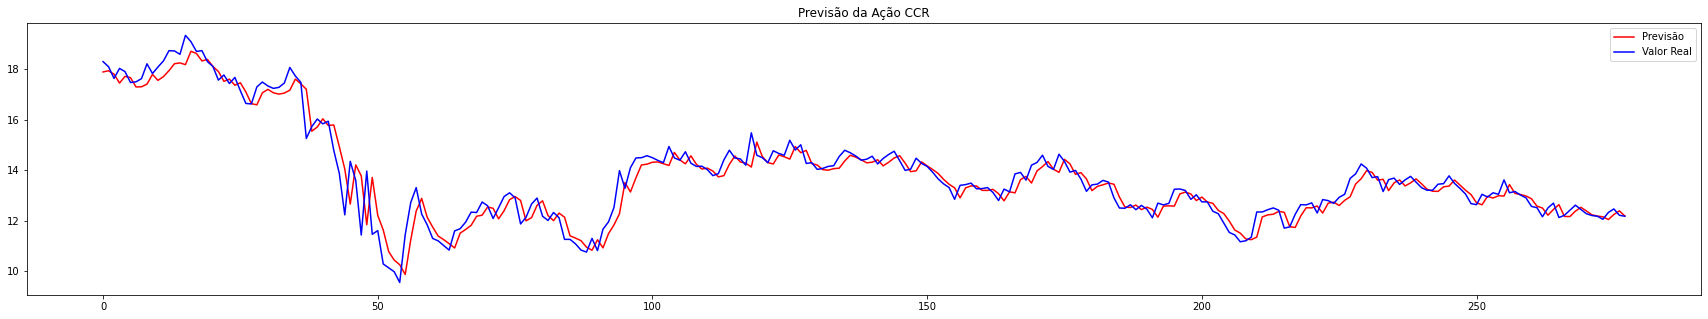

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.plot(previsao, color='red', label='Previsão')
plt.plot(teste_real, color='blue', label='Valor Real')
plt.title("Previsão da Ação CCR")
plt.legend()
plt.show()

In [ ]:
previsao_tabela = pd.DataFrame(previsao, columns=['Previsão'])
real_tabela = pd.DataFrame(teste_real, columns=['Valor real'])
diferenca = pd.DataFrame(previsao_tabela.values - real_tabela.values, columns=['Diferença'])
tabela = pd.concat((previsao_tabela, real_tabela, diferenca), axis=1)
tabela.head()

,Previsão,Valor real,Diferença
0,17.882463,18.291737,-0.409273
1,17.930294,18.089565,-0.159271
2,17.794834,17.627457,0.167377
3,17.442783,18.022173,-0.579390
4,17.707808,17.897020,-0.189213


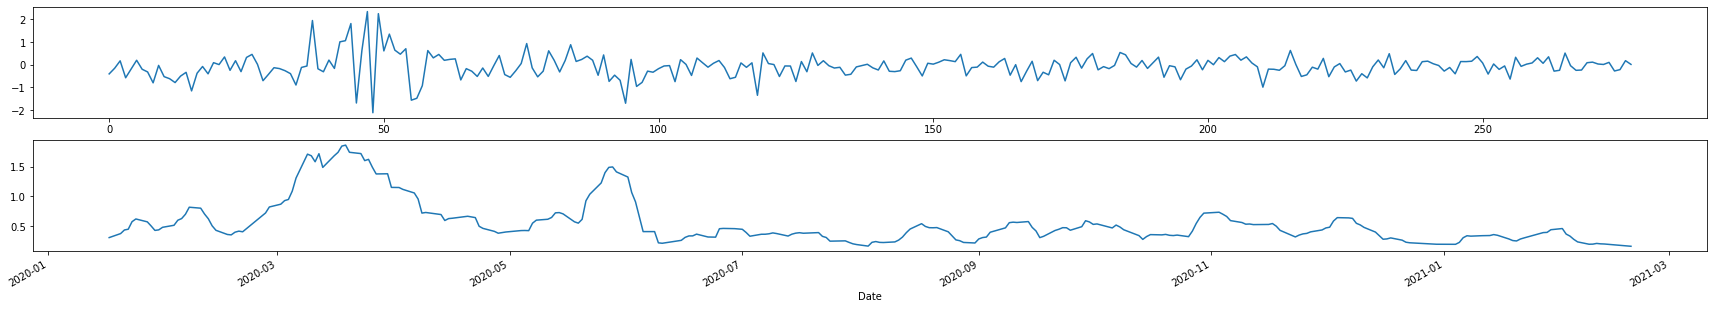

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
plt.subplot(2,1,1)
tabela['Diferença'].plot(kind='line', label='Diferença entre o valor real e a predição')
plt.subplot(2,1,2)
ccr['2020':]['Adj Close'].rolling(12).std().plot(label='Desvio padrão da média móvel')
plt.show()